***
# Irrigation Model Lab
### Simulation Site: Valença do Douro, Portugal
### Objective: Estimation of Vineyard Water Requirements
***

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Definitions
ROW_SPACING = 2
VINE_SPACING = 1.1

***
# Data gathering for the model
***

In [2]:
# Load CSV files
et0_df = pd.read_csv('output_data/estimated_et0.csv')
kc_df = pd.read_csv('output_data/estimated_gdd_kc.csv')

***
# Irrigation Model
***

In [3]:
# Constants
irrigation_efficiency = 0.85  # Irrigation efficiency (IE)
effective_precipitation_factor = 0.70  # Effective precipitation factor

print(f"[{datetime.now()}] Estimating irrigation requirements with provided data.")

# Ensure the 'date' columns are datetime type for merging
et0_df['date'] = pd.to_datetime(et0_df['date'], format='%d/%m/%Y')
kc_df['date'] = pd.to_datetime(kc_df['date'], format='%d/%m/%Y')

# Merge the dataframes on the 'date' column
irrigation_df = pd.merge(et0_df, kc_df, on='date')

# Remove irrelavant information
irrigation_df.drop(columns=['max_temp_c', 'min_temp_c', 'gdd', 'cumsum_gdd'], inplace=True)

# Calculate ETc (Crop Evapotranspiration)
irrigation_df['estimated_etc'] = irrigation_df['kc'] * irrigation_df['estimated_et0']

# Calculate Effective Precipitation (Pe)
irrigation_df['Pe'] = irrigation_df['total_precip'] * effective_precipitation_factor

# Calculate Net Irrigation Requirement (NIR)
irrigation_df['NIR'] = irrigation_df['estimated_etc'] - irrigation_df['Pe']

# Set NIR to 0 where it is below 0
irrigation_df['NIR'] = np.where(irrigation_df['NIR'] < 0, 0, irrigation_df['NIR'])

# Calculate Gross Irrigation Requirement (GIR)
irrigation_df['GIR'] = irrigation_df['NIR'] / irrigation_efficiency

# Calculate the total water requirement in liters per hectare (1 ha = 10,000 m²)
# Convert mm/day to liters/day (1 mm of water over 1 m² = 1 liter)
irrigation_df['irrigation_l_per_ha'] = irrigation_df['GIR'] * 10000

# Calculate the total water requirement in liters per vine (considering vine spacing)
irrigation_df['irrigation_l_per_vine'] = irrigation_df['GIR'] * (ROW_SPACING * VINE_SPACING)

# Set 'datetime' as the index
irrigation_df.set_index('date', inplace=True)
    
# Change date format to day-month-year hour:minute
irrigation_df.index = irrigation_df.index.strftime('%d/%m/%Y')

# Store the data on local csv file
irrigation_df.index.name = 'date'
irrigation_df.to_csv((f"output_data/estimated_irrigation.csv"))

# Print the processed DataFrame (debug)
# print(irrigation_df)

# Print information
print(f"[{datetime.now()}] Irrigation requirements have been successfully estimated.")

[2024-08-13 20:02:03.402477] Estimating irrigation requirements with provided data.
[2024-08-13 20:02:03.409734] Irrigation requirements have been successfully estimated.


## Estimated Data Analysis

Irrigation Requirements for 06/08/2024: GIR is 4.88 mm/day or 48841.91 l/ha/day, equivalent to 10.75 liters per grapevine (for Rs = 2, Vs = 1.1)
Irrigation Requirements for 07/08/2024: GIR is 4.76 mm/day or 47581.48 l/ha/day, equivalent to 10.47 liters per grapevine (for Rs = 2, Vs = 1.1)
Irrigation Requirements for 08/08/2024: GIR is 4.85 mm/day or 48453.37 l/ha/day, equivalent to 10.66 liters per grapevine (for Rs = 2, Vs = 1.1)
Irrigation Requirements for 09/08/2024: GIR is 4.65 mm/day or 46454.03 l/ha/day, equivalent to 10.22 liters per grapevine (for Rs = 2, Vs = 1.1)
Irrigation Requirements for 10/08/2024: GIR is 4.17 mm/day or 41686.00 l/ha/day, equivalent to 9.17 liters per grapevine (for Rs = 2, Vs = 1.1)
Irrigation Requirements for 11/08/2024: GIR is 3.99 mm/day or 39884.56 l/ha/day, equivalent to 8.77 liters per grapevine (for Rs = 2, Vs = 1.1)
Irrigation Requirements for 12/08/2024: GIR is 3.57 mm/day or 35710.95 l/ha/day, equivalent to 7.86 liters per grapevine (for Rs = 2

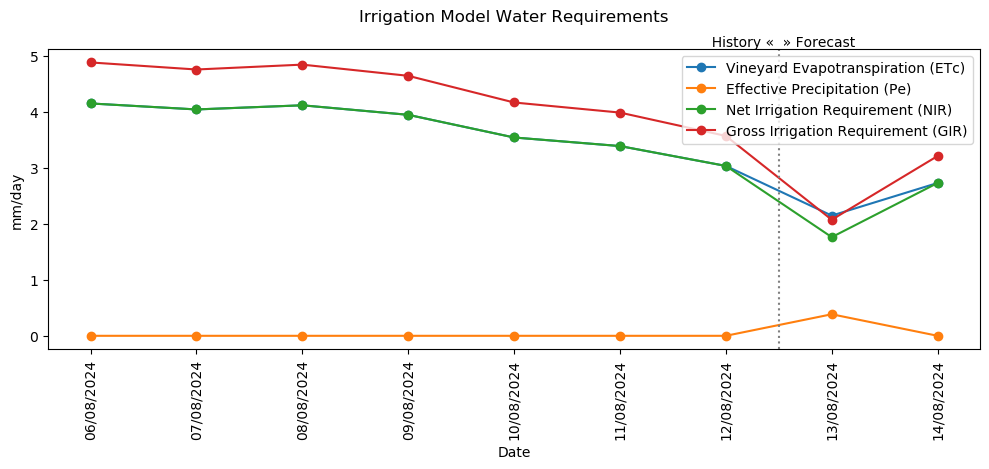

In [4]:
# Translate collumns to name
def irrigation_translation(column):
    if (column == "estimated_etc"): param = "Vineyard Evapotranspiration (ETc)"
    if (column == "Pe"): param = "Effective Precipitation (Pe)"
    if (column == "NIR"): param = "Net Irrigation Requirement (NIR)"
    if (column == "GIR"): param = "Gross Irrigation Requirement (GIR)"
    return param

# Plot Style Function
def applyPlotStyle():
    plt.title(f"Irrigation Model Water Requirements", pad=20)
    plt.xlabel('Date')
    plt.ylabel('mm/day')
    plt.xticks(rotation=90)
    plt.tight_layout()
    x_pos = len(irrigation_df)-2.5
    plt.axvline(x=x_pos, color='gray', linestyle=':')
    y_min, y_pos = plt.ylim()
    plt.text(len(irrigation_df)-2.5, y_pos, '  History «  » Forecast', va='bottom', ha='center')
    
# Plot estimated reference evapotranspiration vs precipitation history
plt.figure().set_figwidth(10)
for column in irrigation_df.columns:
    if column in ["estimated_etc", "Pe", "NIR", "GIR"]:
        param = irrigation_translation(column)
        plt.plot(irrigation_df.index.to_numpy(), irrigation_df[column].to_numpy(), '-o', label=param)
plt.legend(loc="upper right")
applyPlotStyle()
plt.savefig(f"output_graphs/estimated_irrigation.png")

# Display the results
for index, row in irrigation_df.iterrows():
    print(f"Irrigation Requirements for {index}: GIR is {row['GIR']:.2f} mm/day or {row['irrigation_l_per_ha']:.2f} l/ha/day, equivalent to {row['irrigation_l_per_vine']:.2f} liters per grapevine (for Rs = 2, Vs = 1.1)")